# SMOTE for Imbalanced Classification with Python

A problem with imbalanced classification is that there are too few examples of the minority class for a model to effectively learn the decision boundary.

Perhaps the most widely used approach to synthesizing new examples is called the Synthetic Minority Oversampling TEchnique, or SMOTE for short. This technique was described by Nitesh Chawla, et al. in their 2002 paper named for the technique titled “SMOTE: Synthetic Minority Over-sampling Technique.”

### Simple explanation

SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line. Specifically, a random example from the minority class is first chosen. Then k of the nearest neighbors for that example are found (typically k=5). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space.

### Important

This procedure can be used to create as many synthetic examples for the minority class as are required. As described in the paper, it suggests first using random undersampling to trim the number of examples in the majority class, then use SMOTE to oversample the minority class to balance the class distribution. A general downside of the approach is that synthetic examples are created without considering the majority class, possibly resulting in ambiguous examples if there is a strong overlap for the classes.

### Imbalanced-Learn Library and SMOTE for Balancing Data

In [9]:
from imblearn.over_sampling import SMOTE


# Generate and plot a synthetic imbalanced classification dataset
from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where

# Oversample with SMOTE and random undersample for imbalanced dataset via a Pipline
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

In [10]:
# define dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

In [11]:
# summarize class distribution
counter = Counter(y)
print(counter)

Counter({0: 9900, 1: 100})


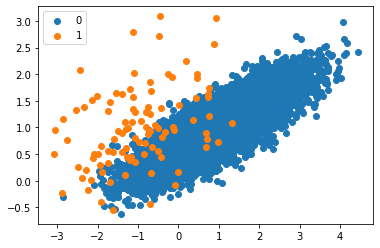

In [12]:
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = where(y == label)[0]
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

Next, we can oversample the minority class using SMOTE and plot the transformed dataset.

In [13]:
# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [14]:
# summarize the new class distribution
counter = Counter(y)
print(counter)

Counter({0: 9900, 1: 9900})


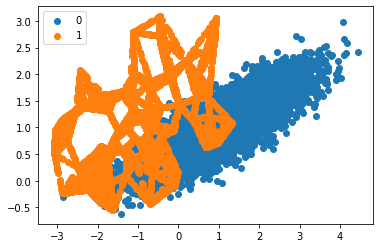

In [15]:
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = where(y == label)[0]
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

The original paper on SMOTE suggested combining SMOTE with random undersampling of the majority class.

In [16]:
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)

The Pipeline can then be applied to a dataset, performing each transformation in turn and returning a final dataset with the accumulation of the transform applied to it, in this case oversampling followed by undersampling.

Counter({0: 1980, 1: 990})


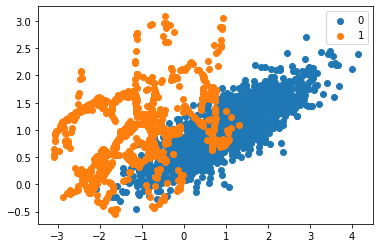

In [18]:
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0, n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# transform the dataset
X, y = pipeline.fit_resample(X, y)

# summarize the new class distribution
counter = Counter(y)
print(counter)

# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = where(y == label)[0]
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

### SMOTE for Classification

In this section, we will look at how we can use SMOTE as a data preparation method when fitting and evaluating machine learning algorithms in scikit-learn.

In [21]:
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from numpy import mean

In [22]:
# define dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
 n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

# define model
model = DecisionTreeClassifier()

# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.769


Now, we can try the same model and the same evaluation method, although use a SMOTE transformed version of the dataset.

In [23]:
# define dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0, n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

# define pipeline
steps = [('over', SMOTE()), ('model', DecisionTreeClassifier())]
pipeline = Pipeline(steps=steps)

# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.830


As mentioned in the paper, it is believed that SMOTE performs better when combined with undersampling of the majority class, such as random undersampling.

We can achieve this by simply adding a RandomUnderSampler step to the Pipeline. We will first oversample the minority class with SMOTE to about a 1:10 ratio, then undersample the majority class to achieve about a 1:2 ratio.

In [24]:
# define dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
 n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

# define pipeline
model = DecisionTreeClassifier()
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)

# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.841


Another area to explore would be to test different values of the k-nearest neighbors selected in the SMOTE procedure when each new synthetic example is created. The default is k=5, although larger or smaller values will influence the types of examples created, and in turn, may impact the performance of the model.

In [25]:
# define dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0, n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

# values to evaluate
k_values = [1, 2, 3, 4, 5, 6, 7]
for k in k_values:
    # define pipeline
    model = DecisionTreeClassifier()
    over = SMOTE(sampling_strategy=0.1, k_neighbors=k)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('over', over), ('under', under), ('model', model)]
    pipeline = Pipeline(steps=steps)
    
    # evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    score = mean(scores)
    print('> k=%d, Mean ROC AUC: %.3f' % (k, score))

> k=1, Mean ROC AUC: 0.825
> k=2, Mean ROC AUC: 0.834
> k=3, Mean ROC AUC: 0.834
> k=4, Mean ROC AUC: 0.829
> k=5, Mean ROC AUC: 0.848
> k=6, Mean ROC AUC: 0.845
> k=7, Mean ROC AUC: 0.842


## SMOTE With Selective Synthetic Sample Generation

In this section, we will review some extensions to SMOTE that are more selective regarding the examples from the minority class that provide the basis for generating new synthetic examples.

### Borderline-SMOTE

A popular extension to SMOTE involves selecting those instances of the minority class that are misclassified, such as with a k-nearest neighbor classification model. We can then oversample just those difficult instances, providing more resolution only where it may be required.

Counter({0: 9900, 1: 100})
Counter({0: 9900, 1: 9900})


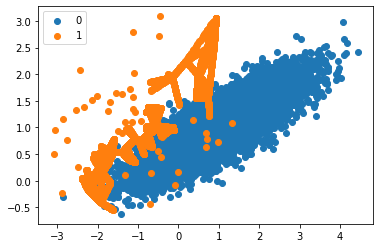

In [26]:
# borderline-SMOTE for imbalanced dataset
from imblearn.over_sampling import BorderlineSMOTE


# define dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0, n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

# summarize class distribution
counter = Counter(y)
print(counter)

# transform the dataset
oversample = BorderlineSMOTE()
X, y = oversample.fit_resample(X, y)

# summarize the new class distribution
counter = Counter(y)
print(counter)

# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = where(y == label)[0]
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

### Borderline-SMOTE SVM

Hien Nguyen, et al. suggest using an alternative of Borderline-SMOTE where an SVM algorithm is used instead of a KNN to identify misclassified examples on the decision boundary.

Counter({0: 9900, 1: 100})
Counter({0: 9900, 1: 9900})


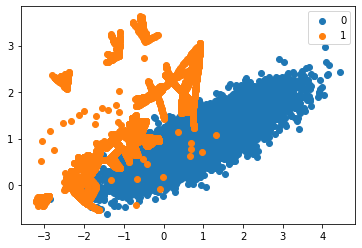

In [27]:
# borderline-SMOTE with SVM for imbalanced dataset
from imblearn.over_sampling import SVMSMOTE

# define dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0, n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

# summarize class distribution
counter = Counter(y)
print(counter)

# transform the dataset
oversample = SVMSMOTE()
X, y = oversample.fit_resample(X, y)

# summarize the new class distribution
counter = Counter(y)
print(counter)

# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = where(y == label)[0]
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

### Adaptive Synthetic Sampling (ADASYN)

Another approach involves generating synthetic samples inversely proportional to the density of the examples in the minority class. That is, generate more synthetic examples in regions of the feature space where the density of minority examples is low, and fewer or none where the density is high.

Counter({0: 9900, 1: 100})
Counter({0: 9900, 1: 9899})


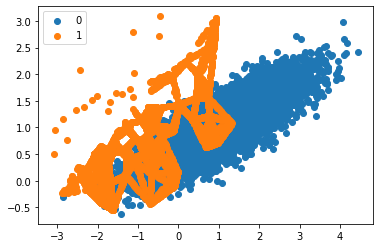

In [28]:
# Oversample and plot imbalanced dataset with ADASYN
from imblearn.over_sampling import ADASYN

# define dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0, n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

# summarize class distribution
counter = Counter(y)
print(counter)

# transform the dataset
oversample = ADASYN()
X, y = oversample.fit_resample(X, y)

# summarize the new class distribution
counter = Counter(y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(y == label)[0]
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()